<a href="https://colab.research.google.com/github/emilypeek1/PensionSystemSustainability/blob/main/Progetto_Fisica_dei_Sistemi_Complessi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import csv
import os.path
import itertools
import copy
import numpy as np
from numpy import linalg as LA
from scipy import linalg
from scipy.io import savemat
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
rc('animation', html='jshtml')
from google.colab import drive

pd.set_option('display.max_columns', None)
#drive.mount('/content/drive', force_remount=True)
#dataset_folder = '/content/drive/MyDrive/Progetto Fisica dei Sistemi Complessi/Datasets/'
dataset_folder = '/content/project-repo/Datasets/'

In [ ]:
#!rm -rf /content/project-repo

In [ ]:
!mkdir /content/plots

if not os.path.isdir(dataset_folder):
  # Clone the entire repo.
  !git clone -l -s git://github.com/emilypeek1/PensionSystemSustainability.git /content/project-repo
  %cd /content/project-repo
  !ls

mkdir: cannot create directory ‘/content/plots’: File exists


In [ ]:
decreasePensions = False                  #10% pension decrease
gradualIncreasePensionAge = False         #one-year pension age increase each year
contrRateIncrease = False                 #contribution rate increase (40% employed, 30% employed and pensioners)
occupationIncrease = False                #10% occupation rate increase
perq = False                              #inflation pensions/retributions perequation

# **Data Extraction**

In [ ]:
def generate_readable_csv(input_file, output_file, remove_dots=False):
  input_file = open(dataset_folder + input_file, 'r')
  output_file = open(dataset_folder + output_file, 'w')
  data = csv.reader(input_file)
  writer = csv.writer(output_file)

  for line in data:
    line = [value.replace('"', '') for value in line]
    if(remove_dots):
      line = [value.replace('.', '') for value in line]
    writer.writerow(line)

  input_file.close()
  output_file.close()
  
def convert_ISTAT_age(age):
  #GE = older than
  #UN = younger than
  if(age == "Y_GE50"):
    return 50
  elif(age == "Y_GE65"):
    return 65  
  elif(age == "Y_GE95"):
    return 95
  elif(age == "Y_GE100"):
    return 100
  elif(age in ["Y_UN4", "Y_UN17"]):
    return 0
  elif(age in ["NDIV", "Y_GE15", "Y15-64", "Y15-34", "Y35-64"]):
    return -1
  else:
    #take the age after the Y and before the -
    return age[1: ].split("-", 1)[0]
    
def process_ISTAT_dataset(file_name, value_name, extra_relevant_cols = {}, support_cols = {}):
  relevant_cols = ['Value']
  for col in extra_relevant_cols:
    relevant_cols.append(col)
  for col in support_cols:
    relevant_cols.append(col)

  readable_file_name = "readable_" + file_name
  if(not os.path.isfile(dataset_folder + readable_file_name)):
    generate_readable_csv(file_name, readable_file_name)
    
  df = pd.read_csv(dataset_folder + readable_file_name, usecols=relevant_cols)

  #remove the invalid rows
  for col in extra_relevant_cols:
    df = df[df[col] != extra_relevant_cols[col]]
  #take only the rows with the specified value and drop the column
  for col in support_cols:
    df = df[df[col] == support_cols[col]].drop(columns=col)

  #rename the columns
  rename_dict = {"SEXISTAT1": "Sex", "ETA1": "Age", "ETA1_A": "Age", "Value": value_name}
  for col in rename_dict.copy():
    if(col not in df.columns):
      rename_dict.pop(col)
  df = df.rename(columns=rename_dict)

  #convert the age to number 
  df['Age'] = df['Age'].map(convert_ISTAT_age)
  df['Age'] = df['Age'].astype(int)
  df = df[df['Age'] != -1]
  df = df.sort_values(by=['Age'])
  
  if ("Sex" in df.columns):
    df['Sex'] = df['Sex'].map(lambda sex: "male" if sex == 1 else "female")
  df = df.drop_duplicates()

  return df

# **Total resident population**

Dataset name: "Popolazione residente al primo gennaio 2021"

Age range: [0,1,...,99,100+]

In [ ]:
def aggregate_ages(df, ranges, columns):
  for min, max in ranges.items():
    for sex in ["male", "female"]:
      condition = (df['Age'] >= min) & (df['Age'] <= max) & (df['Sex'] == sex)
      for col in columns:
        df.loc[(df['Age'] == min) & (df['Sex'] == sex), col] = df.loc[condition, col].sum()
      df = df.drop(df[(df['Age'] > min) & (df['Age'] <= max) & (df['Sex'] == sex)].index)
  
  return df

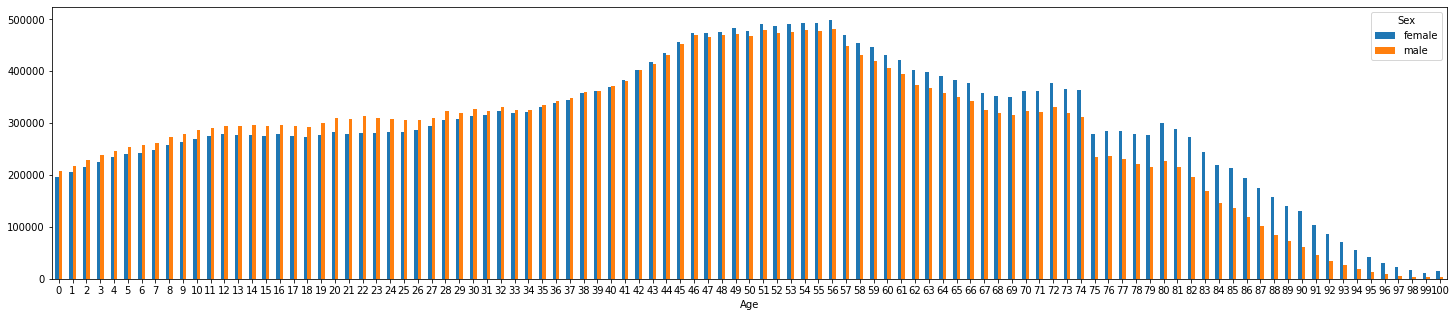

In [ ]:
total_residents = process_ISTAT_dataset("ResidentPopulation.csv", value_name="Population", extra_relevant_cols={"SEXISTAT1": 9, "ETA1": "TOTAL"}, support_cols={"STATCIV2": 99, "Territorio": "Italia"})

#ranges = {0:4, 5:9, 10:14, 15:19, 20:24, 25:29, 30:34, 35:39, 40:44, 45:49, 50:54, 55:59, 60:64, 65:69, 70:74, 75:79, 80:84, 85:89, 90:94, 95:99}
#total_residents_agg = aggregate_ages(total_residents, ranges, ["Population"])

total_residents_pivoted = total_residents.pivot(index='Age', columns='Sex', values='Population')
ax = total_residents_pivoted.plot(kind='bar', rot=0, figsize=(25,5))
#xlabels = total_residents_agg['Age'].unique()
#xlabels = [str(age) + "-" + str(age + 4) for age in xlabels]
#xlabels[-1] = "100+"
#ax.set_xticklabels(xlabels)
plt.show()

Total population: 59236213


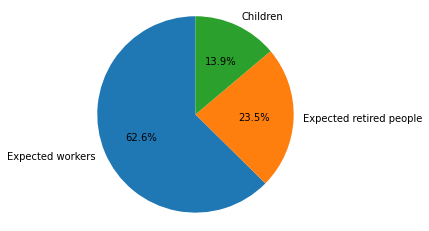

Inverse old-age dependency ratio: 2.660254601879808


In [ ]:
total_pop = total_residents['Population'].sum()
print("Total population: " + str(total_pop))
expected_workers = total_residents.loc[(total_residents["Age"] >= 16) & (total_residents["Age"] <= 64), 'Population'].sum()
expected_retired =  total_residents.loc[total_residents["Age"] >= 65, 'Population'].sum()

fig1, ax1 = plt.subplots()
ax1.pie([expected_workers/total_pop, expected_retired/total_pop, (total_pop - (expected_workers + expected_retired))/total_pop], 
        labels=["Expected workers", "Expected retired people", "Children"], autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()
print("Inverse old-age dependency ratio: " + str(expected_workers/float(expected_retired)))

# **Immigrant population**

Dataset name: "Stranieri residenti al primo gennaio 2021"

Age range: [0,1,...,99,100+]

Total immigrant population: 5171894


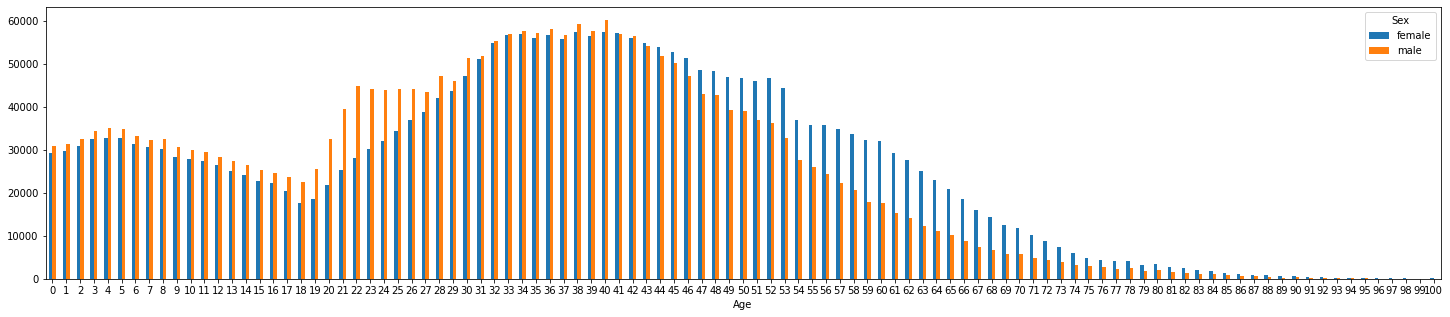

In [ ]:
immigrants = process_ISTAT_dataset("ImmigrantPopulation.csv", value_name="Population", extra_relevant_cols={"SEXISTAT1": 9, "ETA1": "TOTAL"}, support_cols={"Territorio": "Italia"})
print("Total immigrant population: " + str(immigrants['Population'].sum()))
immigrants_pivoted = immigrants.pivot(index='Age', columns='Sex', values='Population')
immigrants_pivoted.plot(kind='bar', rot=0, figsize=(25,5))
plt.show()

# **Italian population**

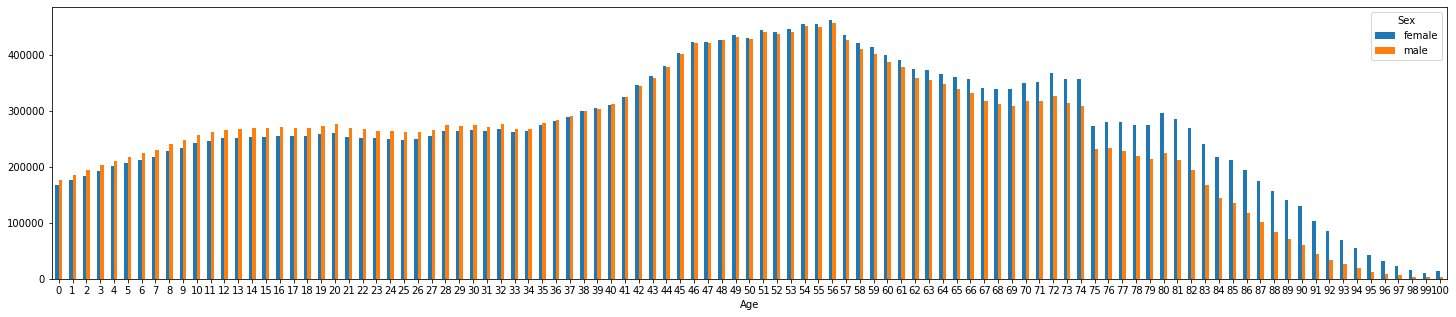

In [ ]:
italians = pd.merge(total_residents,immigrants,on=["Sex", "Age"])
italians["Population"] = italians["Population_x"] - italians["Population_y"]
italians = italians.drop(columns=["Population_x", "Population_y"])
italians_pivoted = italians.pivot(index='Age', columns='Sex', values='Population')
italians_pivoted.plot(kind='bar', rot=0, figsize=(25,5))
plt.show()

# **Survival Rates**

Dataset name: "Tavole di mortalità - singole età" (year 2019 - before Covid)

Age range: [0,1,...,119]

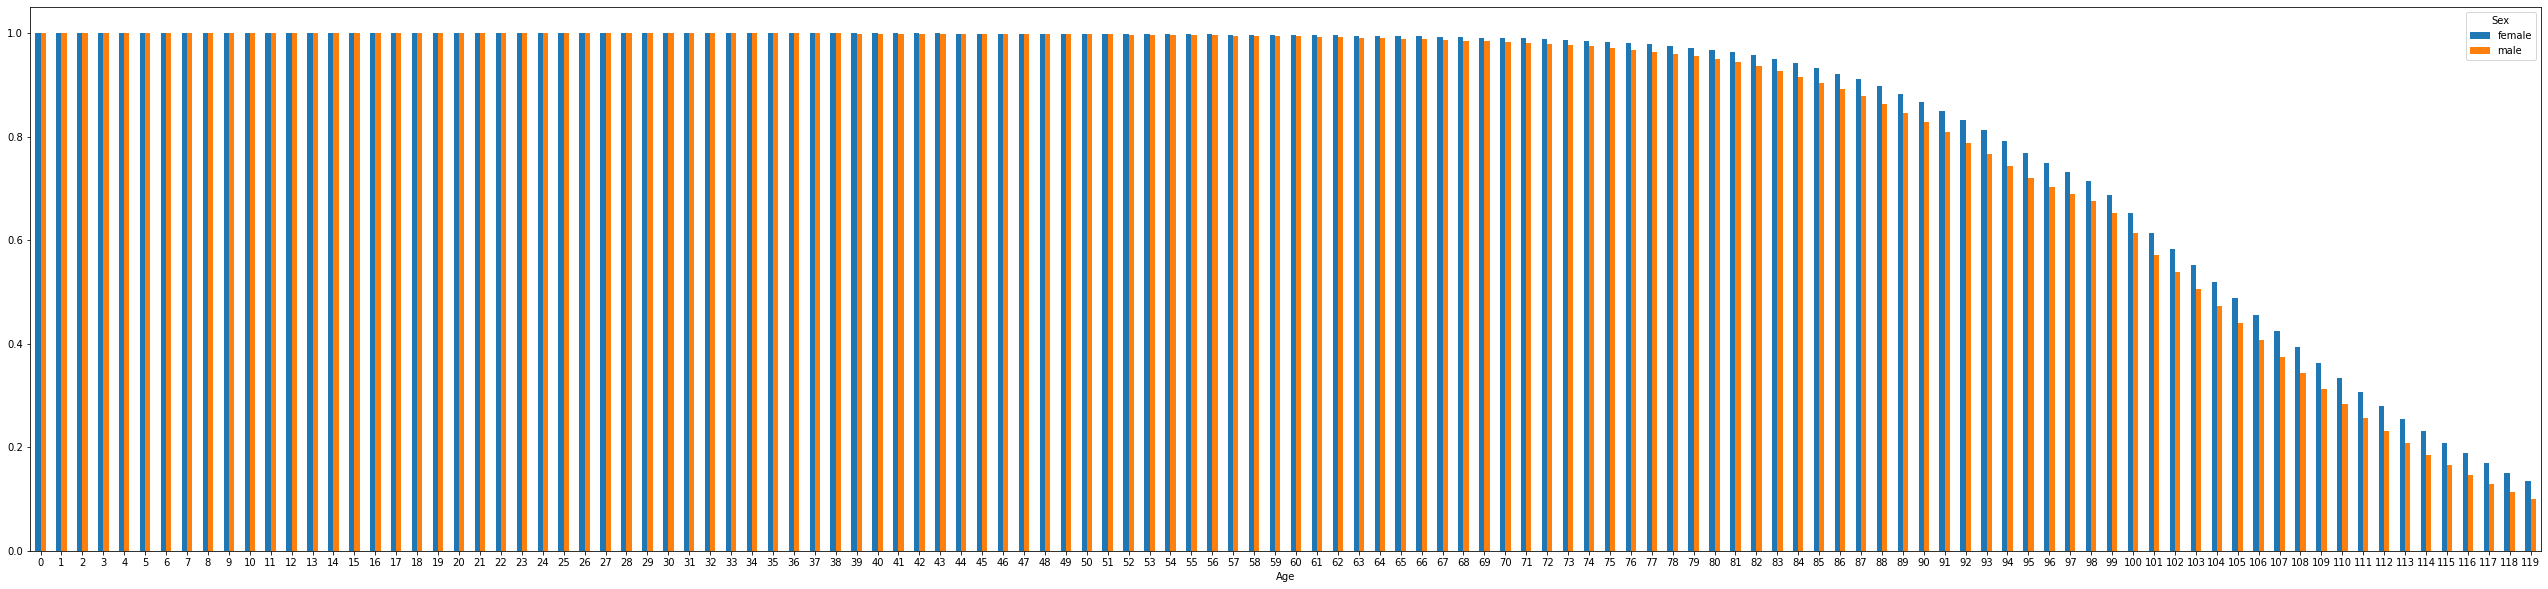

In [ ]:
survival_rates = process_ISTAT_dataset("SurvivalRates2019.csv", value_name="Survival Rate", extra_relevant_cols={"SEXISTAT1": 9, "ETA1": "TOTAL"}, support_cols={"TIPO_DATO15": "PROJPROB", "Territorio": "Italia"})

survival_rates_pivoted = survival_rates.pivot(index='Age', columns='Sex', values='Survival Rate')
survival_rates_pivoted.plot(kind='bar', rot=0, figsize=(45,10))
plt.show()

# **Birth Rates** 

Dataset name: "Madre - età e cittadinanza"

Age range: [0-17,18,19,...,49,50+]

In [ ]:
def compute_birth_rate(births, population, citizenship):
    birth_rates = pd.merge(births[births["CITTADINANZA"] == citizenship], population[population["Sex"] == "female"].drop(columns="Sex"),on=["Age"])
    birth_rates["Birth Rate"] = birth_rates["Births"] / birth_rates["Population"]
    birth_rates = birth_rates.drop(columns=["Births", "Population"])
    return birth_rates

Total Italian birth rate: 1.1358972039987958
Total immigrant birth rate: 1.845627705183494


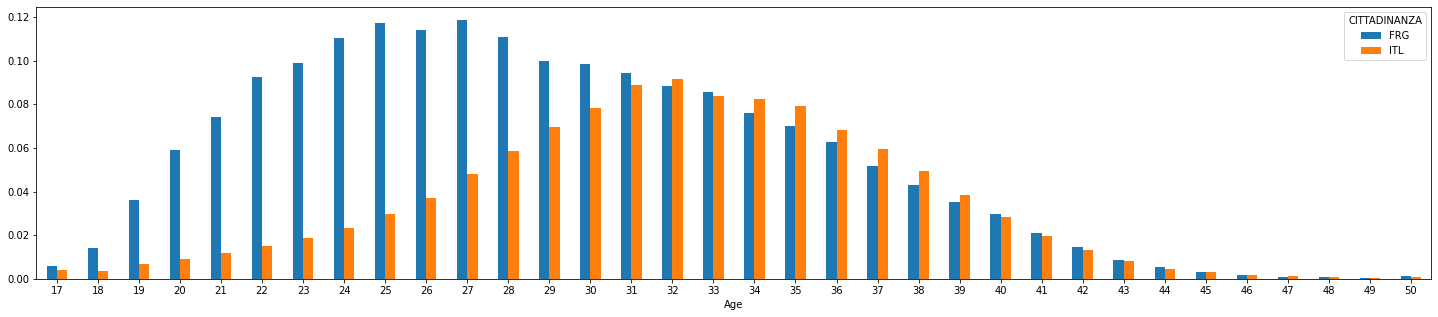

In [ ]:
births = process_ISTAT_dataset("Natality2019.csv", value_name="Births", extra_relevant_cols={"ETA1_A": "TOTAL", "CITTADINANZA": "TOTAL"}, support_cols={"TIME": 2020, "Territorio di residenza": "Italia"})
total_residents_2019 = process_ISTAT_dataset("ResidentPopulation2019.csv", value_name="Population", extra_relevant_cols={"SEXISTAT1": 9, "ETA1": "TOTAL"}, support_cols={"STATCIV2": 99, "Territorio": "Italia"})
immigrants_2019 = process_ISTAT_dataset("ImmigrantPopulation2019.csv", value_name="Population", extra_relevant_cols={"SEXISTAT1": 9, "ETA1": "TOTAL"}, support_cols={"Territorio": "Italia"})
italians_2019 = pd.merge(total_residents_2019,immigrants_2019,on=["Sex", "Age"])
italians_2019["Population"] = italians_2019["Population_x"] - italians_2019["Population_y"]
italians_2019 = italians_2019.drop(columns=["Population_x", "Population_y"])

italians_birth_rates = compute_birth_rate(births, italians_2019, "ITL")
print("Total Italian birth rate: " + str(italians_birth_rates['Birth Rate'].sum()))
immigrants_birth_rates = compute_birth_rate(births, immigrants_2019, "FRG")
print("Total immigrant birth rate: " + str(immigrants_birth_rates['Birth Rate'].sum()))
birth_rates = pd.concat([italians_birth_rates,immigrants_birth_rates])

birth_rates.loc[birth_rates["Age"] == 0, "Age"] = 17

#add missing rows
age_range = list(np.arange(0, 101))*2
ctz_column = ["FRG"]*101 + ["ITL"]*101
birth_rates = birth_rates.merge(pd.DataFrame({'Age':age_range, "CITTADINANZA":ctz_column}), on=['Age', "CITTADINANZA"], how='outer')
birth_rates = birth_rates.sort_values(by=['Age'])

#Accumulative boundary condition for 50+
#birth rate equal to 0 if age < 17 or age > 50
birth_rates = birth_rates.fillna(0)

birth_rates_pivoted = birth_rates.pivot(index='Age', columns='CITTADINANZA', values='Birth Rate')
birth_rates_pivoted = birth_rates_pivoted.drop(range(0,17))
birth_rates_pivoted = birth_rates_pivoted.drop(range(51,101))
birth_rates_pivoted.plot(kind='bar', rot=0, figsize=(25,5))
plt.show()

# **Emigrant departures**

Dataset name: "Emigrati - cittadinanza"

Age range: [0-17,18-39,40-64,65+]

In [ ]:
def add_missing_rows(df, ranges, column_name):
  #add missing rows
  age_range = list(np.arange(0, 100))*2
  sex_column = ["male"]*100 + ["female"]*100
  df = df.merge(pd.DataFrame({'Age':age_range, "Sex":sex_column}), on=['Age', "Sex"], how='outer')
  df = df.sort_values(by=['Age'])

  #replace the missing years with average in range
  for min, max in ranges.items():
      df = fill_with_avg(df, min, max, column_name)

  return df

In [ ]:
def fill_with_avg(df, min, max, column):
  range_len = float(max + 1 - min) 
  df.loc[(df['Sex'] == "male") & (df['Age'] >= min) & (df['Age'] <= max), column] = df.loc[(df['Sex'] == "male") & (df['Age'] == min), column].values[0]/range_len
  df.loc[(df['Sex'] == "female") & (df['Age'] >= min) & (df['Age'] <= max), column] = df.loc[(df['Sex'] == "female") & (df['Age'] == min), column].values[0]/range_len
  return df

Total emigrant departures each year: 159884


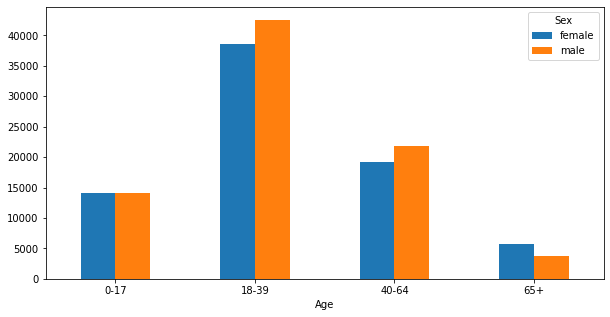

In [ ]:
emigrants = process_ISTAT_dataset("EmigrantDepartures.csv", value_name="Population", extra_relevant_cols={"SEXISTAT1": 9, "ETA1": "TOTAL"}, support_cols={"Territorio di origine": "Italia", "Paese di cittadinanza" :"Totale"})
print("Total emigrant departures each year: " + str(emigrants['Population'].sum()))

emigrants_pivoted = emigrants.pivot(index='Age', columns='Sex', values='Population')
ax = emigrants_pivoted.plot(kind='bar', rot=0, figsize=(10,5))
ax.set_xticklabels(["0-17", "18-39", "40-64", "65+"])
plt.show()

#replace the missing years with average in range
ranges = {0: 17, 18:39, 40:64, 65:99}
emigrants = add_missing_rows(emigrants, ranges, "Population")

# **Immigrant arrivals**

Dataset name: "Immigrati - cittadinanza"

Age range: [0-17,18-39,40-64,65+]

Total immigrant arrivals each year: 247526


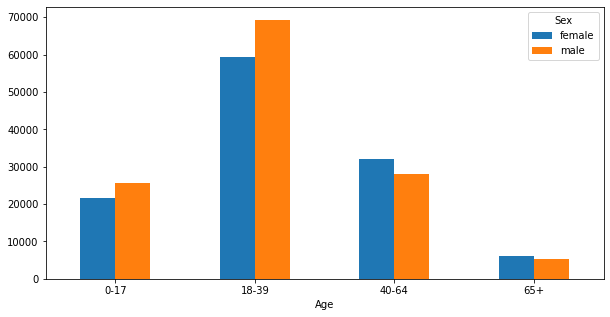

In [ ]:
immigrant_year = process_ISTAT_dataset("ImmigrantArrivals.csv", value_name="Population", extra_relevant_cols={"SEXISTAT1": 9, "ETA1": "TOTAL"}, support_cols={"Territorio di origine": "Totale", "Paese di cittadinanza" :"Totale"})
print("Total immigrant arrivals each year: " + str(immigrant_year['Population'].sum()))

immigrant_year_pivoted = immigrant_year.pivot(index='Age', columns='Sex', values='Population')
ax = immigrant_year_pivoted.plot(kind='bar', rot=0, figsize=(10,5))
ax.set_xticklabels(["0-17", "18-39", "40-64", "65+"])
plt.show()

#replace the missing years with average in range
ranges = {0: 17, 18:39, 40:64, 65:99}
immigrant_year = add_missing_rows(immigrant_year, ranges, "Population")

# **Pensions**
Dataset name: "Pensioni" (year 2019 - after Fornero reform and before Quota 100 and Quota 102)

Age ranges: [0-4, 5-9,...,90-94, 95+]



In [ ]:
def fix_pension_types(df):
  df = df.drop(df[(df['TIPO_PENSIONE1'] == "CIVDIS") | (df['TIPO_PENSIONE1'] == "WAR") | (df['TIPO_PENSIONE1'] == "NOCONT") | (df['TIPO_PENSIONE1'] == "OSDCOMP")].index)
  names = { "OLSEN1": "longevity", "SURV": "survival", "COMP": "injury", "DISAB1": "disability"}
  df['TIPO_PENSIONE1'] = df['TIPO_PENSIONE1'].apply(lambda x: names[x])
  return df

In [ ]:
ranges = {0:4, 5:9, 10:14, 15:19, 20:24, 25:29, 30:34, 35:39, 40:44, 45:49, 50:54, 55:59, 60:64, 65:69, 70:74, 75:79, 80:84, 85:89, 90:94, 95:99}
total_residents_2019 = aggregate_ages(total_residents_2019, ranges, ["Population"])
#accumulation of the 100+ in the 95 age class
for sex in ["female", "male"]:
  total_residents_2019.loc[(total_residents_2019['Age'] == 95) & (total_residents_2019['Sex'] == sex), 'Population'] = total_residents_2019.loc[(total_residents_2019['Age'] == 95) & (total_residents_2019['Sex'] == sex), 'Population'].item() + total_residents_2019.loc[(total_residents_2019['Age'] == 100) & (total_residents_2019['Sex'] == sex), 'Population'].item()
total_residents_2019 = total_residents_2019.drop(total_residents_2019[total_residents_2019['Age'] == 100].index)

Youngest pensioner's age: 40


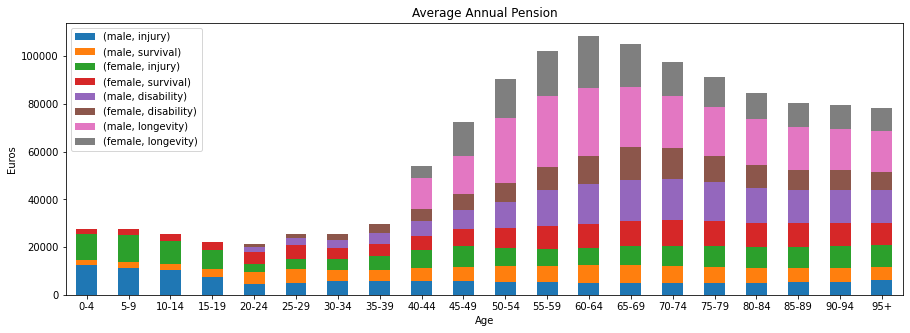

In [ ]:
pensions = process_ISTAT_dataset("Pensions.csv", value_name="Pensions", extra_relevant_cols={"SEXISTAT1": 9, "ETA1": "TOTAL", "TIPO_PENSIONE1": "ALL"}, support_cols={"TIPO_DATO38": "P_NSNU", "Territorio": "Italia"})
pension_amounts = process_ISTAT_dataset("Pensions.csv", value_name="Pension amount (thousands)", extra_relevant_cols={"SEXISTAT1": 9, "ETA1": "TOTAL", "TIPO_PENSIONE1": "ALL"}, support_cols={"TIPO_DATO38": "ANP_NS", "Territorio": "Italia"})

pensions = fix_pension_types(pensions)
pension_amounts = fix_pension_types(pension_amounts)

pensions = pensions.merge(total_residents_2019, on=['Age', "Sex"], how='outer')
pensions = pensions.merge(pension_amounts, on=['Age', "Sex", "TIPO_PENSIONE1"], how='inner')
#how many pensions for person in each category (e.g. a person can have both the old age pension and the invalidity pension)
pensions['Pension Ratio'] = (pensions['Pensions'] / pensions['Population']).apply(lambda x: x if x <= 1 else 1)
pensions['Avg Pension 2019'] = (pensions['Pension amount (thousands)'].apply(lambda x: x*1000) / pensions['Pensions'])

#revaluation was 0.5% in year 2020 and 0 in year 2021
pensions['Target Pension'] = pensions['Avg Pension 2019'].apply(lambda x: x + x * 0.005)
#set as target old-age pension the pension in age range 65-69

pensions2021 = pensions.copy()
youngest_pensioner_age = pensions.loc[pensions['TIPO_PENSIONE1'] == "longevity", "Age"].min()
print("Youngest pensioner's age: " + str(youngest_pensioner_age))

if(decreasePensions):
  pensions["Target Pension"] = pensions["Target Pension"].apply(lambda x: x * 0.9)

pensions2021_pivoted = pensions2021.pivot(index=['Age'], columns=['Sex', 'TIPO_PENSIONE1'], values='Target Pension')
ax = pensions2021_pivoted.plot(kind='bar', stacked=True, rot=0, title = "Average Annual Pension", figsize=(15,5))
ax.legend().set_title(None)
xlabels = pensions2021['Age'].unique()
xlabels = [str(age) + "-" + str(age + 4) for age in xlabels]
xlabels[-1] = "95+"
ax.set_xticklabels(xlabels)
ax.set_ylabel("Euros")
plt.show()

In [ ]:
def flatten_list(t):
  return [item for sublist in t for item in sublist]

def add_missing_pension_types(df, pension_types):
  other_df = pd.DataFrame(list(itertools.product(list(ranges.keys()), ["male", "female"], pension_types)), columns=["Age", "Sex", "TIPO_PENSIONE1"])
  df = df.merge(other_df, on=['Age', "Sex", "TIPO_PENSIONE1"], how='outer')
  df = df.sort_values(by=['Age'])
  df = df.fillna(0)
  return df


In [ ]:
pension_constants_0 = {}
pension_constants_1 = {}

#add missing pension types rows
pension_types = pensions['TIPO_PENSIONE1'].unique()
pensions = add_missing_pension_types(pensions, pension_types)
pensions2021 = add_missing_pension_types(pensions2021, pension_types)

#add missing ages
for sex, pension_type, column_name in itertools.product(["male", "female"], pension_types, ["Pension Ratio", "Target Pension"]):
  pension_constants_0[sex + " " + pension_type + " " + column_name] = np.repeat(pensions2021[(pensions2021["Sex"] == sex) & (pensions2021['TIPO_PENSIONE1'] == pension_type)][column_name].to_numpy(), 5)
  pension_constants_1[sex + " " + pension_type + " " + column_name] = np.repeat(pensions[(pensions["Sex"] == sex) & (pensions['TIPO_PENSIONE1'] == pension_type)][column_name].to_numpy(), 5)

#**Employment**

Dataset names:
- "Occupati" 
- "Occupati - Tempo pieno/parziale, posizione professionale, età"

Age range: [15-24, 25-34, 35-44, 45-54, 55-64, 65+]

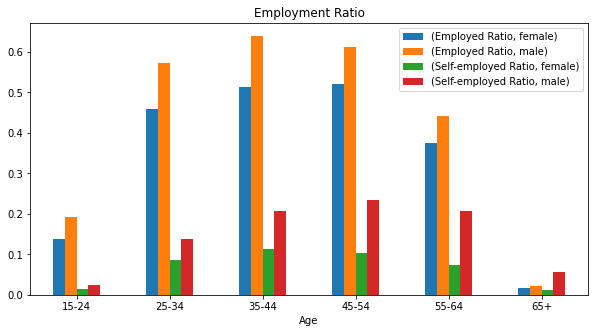

In [ ]:
#extract the working probabilities
contributors = process_ISTAT_dataset("Workers.csv", value_name="Workers (thousands)", extra_relevant_cols={"SEXISTAT1": 9, "ETA1": "TOTAL"}, support_cols={"Territorio": "Italia", "TIME": "2019"})
employed = process_ISTAT_dataset("Employed.csv", value_name="Employed (thousands)", extra_relevant_cols={"SEXISTAT1": 9, "ETA1": "TOTAL"}, support_cols={"REGIME_ORARIO": 9, "Territorio": "Italia", "CARATT_OCC": 9, "TIME": "2019"})

ranges = {0:14, 15:24, 25:34, 35:44, 45:54, 55:64, 65:99}
total_residents_2019 = aggregate_ages(total_residents_2019, ranges, ["Population"])

contributors = contributors.merge(total_residents_2019, on=['Age', "Sex"], how='inner')
contributors = contributors.merge(employed, on=['Age', "Sex"], how='inner')

contributors = contributors.fillna(0)
contributors['Workers'] = contributors['Workers (thousands)'].apply(lambda x: x*1000) 
contributors['Employed'] = contributors['Employed (thousands)'].apply(lambda x: x*1000) 
contributors['Self-employed'] = contributors['Workers'] - contributors['Employed']
contributors = contributors.drop(columns=['Workers (thousands)', 'Employed (thousands)'])

worker_types = ["Employed", "Self-employed"]
for wtype in worker_types:
  contributors[wtype + ' Ratio'] = (contributors[wtype] / contributors['Population'])
contributors["EPSP Ratio"] = contributors["Employed Ratio"]/contributors["Self-employed Ratio"]

contributors2021 = contributors.copy()

if(occupationIncrease):
  for wtype in worker_types:
    contributors[wtype + ' Ratio'] = contributors[wtype + ' Ratio'].apply(lambda x: x * 1.1)
  contributors["EPSP Ratio"] = contributors["Employed Ratio"]/contributors["Self-employed Ratio"]

contributors2021_pivoted = contributors2021.pivot(index=['Age'], columns=['Sex'], values=['Employed Ratio', "Self-employed Ratio"])
ax = contributors2021_pivoted.plot(kind='bar', rot=0, title="Employment Ratio", figsize=(10,5))
ax.legend().set_title(None)
ax.set_xticklabels(["15-24", "25-34", "35-44", "45-54", "55-64", "65+"])
plt.show()

#**Retributions**
Dataset name: "2020 a.i. 2019 / IRPEF / Persone fisiche / Tutte le tipologie di contribuenti - Classi di reddito e Classi di Età"

Age range: [15-24, 25-44, 45-64, 65+]

In [ ]:
def avg_income(income):
  if(income in ["minore di -1000", "da -1000 a 0", "zero"]):
    return -1
  elif(income == "oltre 300000"):
    return 100000
  else:
    min, max = income[3:].split(" a ", 1)
    avg = (int(max) + int(min))/2.0
    return avg

def process_Finanze_dataset(file_name, relevant_cols):
  readable_file_name = "readable_" + file_name
  if(not os.path.isfile(dataset_folder + readable_file_name)):
    generate_readable_csv(file_name, readable_file_name, remove_dots=True)
    
  df = pd.read_csv(dataset_folder + readable_file_name, sep=";", usecols=relevant_cols)

  #rename the columns
  rename_dict = {"Classi di eta'": "Age", 
                 "Sesso" : "Sex",
                 "Classi di reddito complessivo in euro":"Income",
                 "Reddito da lavoro dipendente e assimilati - Frequenza":"Employed Incomes",
                 "Reddito da lavoro dipendente e assimilati - Ammontare in euro":"Employed Income Amount", 
                 "Altri redditi assimilati al lavoro dipendente - Frequenza": "Other Employed Incomes",
                 "Altri redditi assimilati al lavoro dipendente - Ammontare in euro":"Other Employed Income Amount", 
                 "Reddito da lavoro autonomo - Frequenza": "Self-employed Incomes", 
                 "Reddito da lavoro autonomo - Ammontare in euro": "Self-employed Income Amount", 
                 "Altri redditi da lavoro autonomo provvigioni e redditi diversi da Mod 770 - Frequenza": "Other Self-employed Incomes",
                 "Altri redditi da lavoro autonomo provvigioni e redditi diversi da Mod 770 - Ammontare in euro": "Other Self-employed Income Amount",
                 "Altri redditi da lavoro autonomo e redditi da recupero start up - Frequenza":"More Self-employed Incomes", 
                 "Altri redditi da lavoro autonomo e redditi da recupero start up - Ammontare in euro":"More Self-employed Income Amount"}
  df = df.rename(columns=rename_dict)


  rel_col = None
  if ("Age" in df.columns):
    #convert the age to number 
    df['Age'] = df['Age'].map(lambda age: 65 if age == "oltre 64" else age.split("-", 1)[0])
    df['Age'] = df['Age'].astype(int)
    df = df[df['Age'] != 0]
    df = df.sort_values(by=['Age'])
    rel_col = "Age"

  if ("Sex" in df.columns):
    df['Sex'] = df['Sex'].map(lambda sex: "male" if sex == "Maschi" else "female")
    df = df.sort_values(by=['Sex'])
    rel_col = "Sex"

  df['Income'] = df['Income'].map(avg_income)
  df = df[df['Income'] != -1]
  for wtype, ivar in itertools.product(worker_types, ["Incomes", "Income Amount"]):
    df[wtype + " " + ivar] = df[wtype + " " + ivar] + df['Other ' + wtype + " " + ivar] 
    if(wtype == "Self-employed"):
       df[wtype + " " + ivar] = df[wtype + " " + ivar] + df['More ' + wtype + " " + ivar] 
       df = df.drop(columns=['More ' + wtype + " " + ivar])
    df = df.drop(columns=['Other ' + wtype + " " + ivar])

  #sum values for rows with same income and age
  cols_sum = {}
  for col in list(df.columns):
    if(col not in [rel_col, "Income"]):
      cols_sum[col] = 'sum'
  df = df.groupby([rel_col, "Income"]).agg(cols_sum).reset_index()
  
  df = df.fillna(0)

  return df

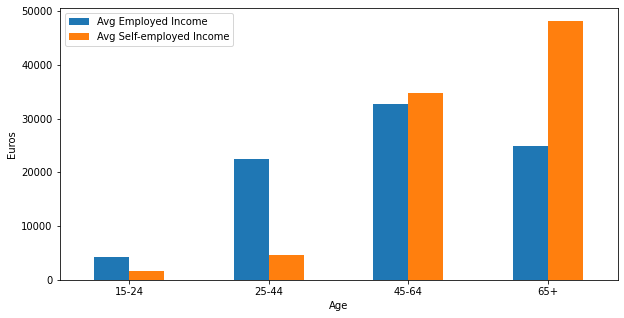

In [ ]:
#extract the incomes
incomes_age = process_Finanze_dataset("IncomeAges20192020.csv",  relevant_cols=["Classi di eta'", "Classi di reddito complessivo in euro", "Reddito da lavoro dipendente e assimilati - Frequenza", "Reddito da lavoro dipendente e assimilati - Ammontare in euro", "Altri redditi assimilati al lavoro dipendente - Frequenza", "Altri redditi assimilati al lavoro dipendente - Ammontare in euro", "Reddito da lavoro autonomo - Frequenza", "Reddito da lavoro autonomo - Ammontare in euro", "Altri redditi da lavoro autonomo provvigioni e redditi diversi da Mod 770 - Frequenza", "Altri redditi da lavoro autonomo provvigioni e redditi diversi da Mod 770 - Ammontare in euro", "Altri redditi da lavoro autonomo e redditi da recupero start up - Frequenza", "Altri redditi da lavoro autonomo e redditi da recupero start up - Ammontare in euro"])
#the income amounts for employed is exclusive of previdential contribution
incomes_age["Employed Income Amount"] = incomes_age["Employed Income Amount"].apply(lambda x: x/0.67)
age_classes = incomes_age['Age'].unique()
for age_class, wtype in itertools.product(age_classes, worker_types):
  #note: the income amount is the total amount for that age and income ranges
  incomes_age.loc[incomes_age["Age"] == age_class, 'Avg ' + wtype + ' Income'] = incomes_age.loc[incomes_age["Age"] == age_class, wtype + ' Income Amount'].sum()  / incomes_age.loc[incomes_age["Age"] == age_class, wtype + ' Incomes'].sum()
incomes_age = incomes_age.drop(columns=["Income", "Employed Incomes", "Employed Income Amount", "Self-employed Incomes", "Self-employed Income Amount"])
incomes_age = incomes_age.fillna(0).drop_duplicates()

ax = incomes_age.set_index("Age").plot(kind='bar', rot=0, figsize=(10,5))
ax.set_xticklabels(["15-24", "25-44", "45-64", "65+"])
ax.set_ylabel("Euros")
plt.show()

Dataset name: "2020 a.i. 2019 / IRPEF / Persone fisiche / Tutte le tipologie di contribuenti - Classi di reddito e Sesso"

Employed GPR: 0.733202325423705
Self-employed GPR: 0.394877469558738


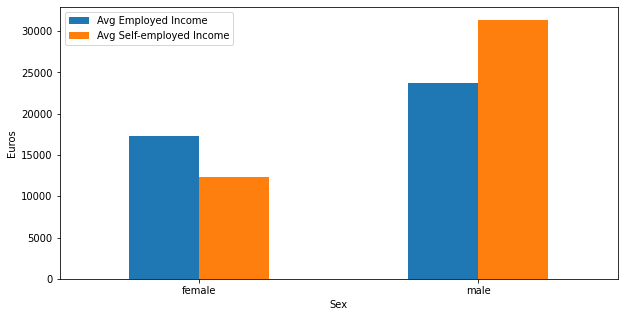

In [ ]:
incomes_gender = process_Finanze_dataset("IncomeSexes20192020.csv",  relevant_cols=["Sesso", "Classi di reddito complessivo in euro", "Reddito da lavoro dipendente e assimilati - Frequenza", "Reddito da lavoro dipendente e assimilati - Ammontare in euro", "Altri redditi assimilati al lavoro dipendente - Frequenza", "Altri redditi assimilati al lavoro dipendente - Ammontare in euro", "Reddito da lavoro autonomo - Frequenza", "Reddito da lavoro autonomo - Ammontare in euro", "Altri redditi da lavoro autonomo provvigioni e redditi diversi da Mod 770 - Frequenza", "Altri redditi da lavoro autonomo provvigioni e redditi diversi da Mod 770 - Ammontare in euro", "Altri redditi da lavoro autonomo e redditi da recupero start up - Frequenza", "Altri redditi da lavoro autonomo e redditi da recupero start up - Ammontare in euro"])
for sex, wtype in itertools.product(["male", "female"], worker_types):
  incomes_gender.loc[incomes_gender["Sex"] == sex, 'Avg ' + wtype + ' Income'] = incomes_gender.loc[incomes_gender["Sex"] == sex, wtype + ' Income Amount'].sum()  / incomes_gender.loc[incomes_gender["Sex"] == sex, wtype + ' Incomes'].sum()
incomes_gender = incomes_gender.drop(columns=["Income", "Employed Incomes", "Employed Income Amount", "Self-employed Incomes", "Self-employed Income Amount"])
incomes_gender = incomes_gender.fillna(0).drop_duplicates()

GPR = {}
GPR['Employed'] = incomes_gender.loc[incomes_gender["Sex"] == "female", "Avg Employed Income"].values[0] / incomes_gender.loc[incomes_gender["Sex"] == "male", "Avg Employed Income"].values[0]
print("Employed GPR: " + str(GPR['Employed']))
GPR['Self-employed'] = incomes_gender.loc[incomes_gender["Sex"] == "female", "Avg Self-employed Income"].values[0] / incomes_gender.loc[incomes_gender["Sex"] == "male", "Avg Self-employed Income"].values[0]
print("Self-employed GPR: " + str(GPR['Self-employed']))
ax = incomes_gender.set_index("Sex").plot(kind='bar', rot=0, figsize=(10,5))
ax.set_ylabel("Euros")
plt.show()

Ni * Si = Nif * Sif + Nim * Sim

Sif = GPR * Sim

Ni * Si = Nif * GPR * Sim + Nim * Sim = Sim(Nif*GPR + Nim)

Sim = (Ni * Si) / (Nif * GPR + Nim)

In [ ]:
def get_incomes_dataset(contr_dataset):
  #use the Gender Pay Ratio to estimate the avg income for each sex and age class
  contr_dataset = contr_dataset.drop(columns=["Workers", "Population", "Employed Ratio", "Self-employed Ratio"])
  ranges = {0:14, 15:24, 25:44, 45:64, 65:99}
  incomes = incomes_age.merge(aggregate_ages(contr_dataset, ranges, ["Employed",  "Self-employed"]), on=["Age"], how='inner')
  for age_class, wtype in itertools.product(age_classes, worker_types):
    #note: the income amount is the total amount for that age and income ranges
    female_workers = incomes.loc[(incomes["Age"] == age_class) & (incomes['Sex'] == 'female'), wtype].values[0]
    male_workers = incomes.loc[(incomes["Age"] == age_class) & (incomes['Sex'] == 'male'), wtype].values[0]
    total_workers = female_workers + male_workers
    avg_income = incomes.loc[incomes["Age"] == age_class, 'Avg ' + wtype + ' Income'].values[0]
    avg_male_income = (total_workers * avg_income) / (female_workers * GPR[wtype] + male_workers)
    incomes.loc[(incomes["Age"] == age_class) & (incomes['Sex'] == 'male'), 'Avg ' + wtype + ' Income'] =  avg_male_income
    incomes.loc[(incomes["Age"] == age_class) & (incomes['Sex'] == 'female'), 'Avg ' + wtype + ' Income'] = GPR[wtype] * avg_male_income

  incomes = incomes.drop(columns=["Employed", "Self-employed"])
  return incomes

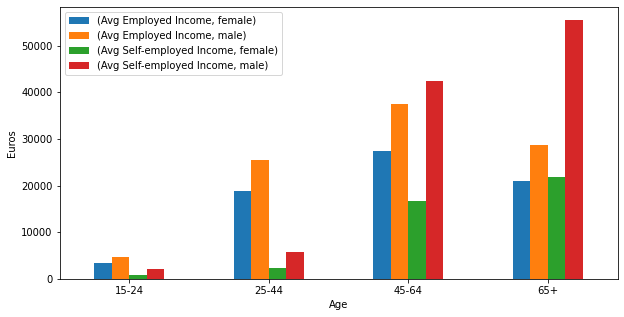

In [ ]:
incomes = get_incomes_dataset(contributors)

incomes_pivoted = incomes.pivot(index=['Age'], columns=['Sex'], values=['Avg Employed Income', "Avg Self-employed Income"])
ax = incomes_pivoted.plot(kind='bar', rot=0, figsize=(10,5))
ax.legend().set_title(None)
ax.set_xticklabels(["15-24", "25-44", "45-64", "65+"])
ax.set_ylabel("Euros")
plt.show()

In [ ]:
def get_retribution_constants(inc, contr):
  retribution_constants = {}

  #income for people aged 0-14 is 0
  zero_array = np.zeros(15)

  for sex, column_name in itertools.product(["male", "female"], ["Employed Income", "Self-employed Income"]):
    incomes_agg = inc[(inc["Sex"] == sex)]["Avg " + column_name].to_numpy()
    incomes_single_age = np.concatenate((zero_array, np.full((1, 10), incomes_agg[0]).flatten()))         #15-24
    rep_dict = {1:20, 2:20, 3:35}
    for k, v in rep_dict.items():
      incomes_single_age = np.concatenate((incomes_single_age, np.full((1, v), incomes_agg[k]).flatten()))
    retribution_constants[sex + " " + column_name] = incomes_single_age

  for sex, column_name in itertools.product(["male", "female"], ["Employed Ratio", "Self-employed Ratio", "EPSP Ratio"]):
    contr_agg = contr[(contr["Sex"] == sex)][column_name].to_numpy()
    ratios_single_age = np.concatenate((zero_array, np.full((1, 10), contr_agg[0]).flatten()))           #15-24
    rep_dict = {1:10, 2:10, 3:10, 4:10, 5:35}
    for k, v in rep_dict.items():
      ratios_single_age = np.concatenate((ratios_single_age, np.full((1, v), contr_agg[k]).flatten()))  
    retribution_constants[sex + " " + column_name] = ratios_single_age

  return retribution_constants

In [ ]:
retribution_constants_0 = get_retribution_constants(incomes, contributors2021)
retribution_constants_1 = get_retribution_constants(incomes, contributors)

# **Leslie Matrix**

float64 arrays

In [ ]:
N = 100    #max age (not included)

total_m = total_residents[total_residents["Sex"] == "male"]["Population"].to_numpy(dtype='int')
total_f = total_residents[total_residents["Sex"] == "female"]["Population"].to_numpy(dtype='int')
x_f = italians[italians["Sex"] == "female"]["Population"].to_numpy(dtype='int')
x_m = italians[italians["Sex"] == "male"]["Population"].to_numpy(dtype='int')
y_f = immigrants[immigrants["Sex"] == "female"]["Population"].to_numpy(dtype='int')
y_m = immigrants[immigrants["Sex"] == "male"]["Population"].to_numpy(dtype='int')

#emigrants each year
e_f = emigrants[emigrants["Sex"] == "female"]["Population"].to_numpy(dtype='int')                  
e_m = emigrants[emigrants["Sex"] == "male"]["Population"].to_numpy(dtype='int')
#immigrants each year
i_f = immigrant_year[immigrant_year["Sex"] == "female"]["Population"].to_numpy(dtype='int')                  
i_m = immigrant_year[immigrant_year["Sex"] == "male"]["Population"].to_numpy(dtype='int')


omega_m = survival_rates[survival_rates["Sex"] == "male"]["Survival Rate"].to_numpy()
omega_f = survival_rates[survival_rates["Sex"] == "female"]["Survival Rate"].to_numpy()
alpha_0 = birth_rates[birth_rates["CITTADINANZA"] == "ITL"]["Birth Rate"].to_numpy()   #italian reproduction rate
alpha_1 = birth_rates[birth_rates["CITTADINANZA"] == "FRG"]["Birth Rate"].to_numpy()   #immigrant reproduction rate
phi = total_f[0]/(total_f[0] + total_m[0])  #sex ratio (at birth)

#L1_m matrix is constant
L1_m = np.diag(omega_m[0:N-1])
L1_m = np.hstack([L1_m, np.zeros((N-1,1))])      
print("L1_m shape: " + str(L1_m.shape))

L1_m shape: (99, 100)


In [ ]:
def update_lambda(omega_f, alpha_s):
  Ls_f = np.diag(omega_f[0:N-1])                  #the second element for slicing (N-1) is not included
  Ls_f = np.hstack([Ls_f, np.zeros((N-1,1))])     #add column on the right
  Ls_f = np.vstack([alpha_s[0:N]*phi, Ls_f])      #add row on top
  #print("Ls_f shape: " + str(Ls_f.shape))

  ds = ((1-phi) * alpha_s[0:N-1]).reshape((1, N-1))
  #print("ds shape: " + str(ds.shape))
  #compute rows
  Lambda1 = np.hstack([Ls_f, np.zeros((N,N))])
  Lambda2 = np.hstack([ds, np.zeros((1,N+1))])
  Lambda3 = np.hstack([np.zeros((N-1,N)), L1_m])

  return np.vstack([Lambda1, Lambda2, Lambda3]) 

In [ ]:
#get weighted average reproduction rate
italian_f_ratio = x_f / total_f
alpha_s_0 = italian_f_ratio * alpha_0 + (1-italian_f_ratio) * alpha_1

Lambda_0 = update_lambda(omega_f, alpha_s_0)
print("Lambda shape: " + str(Lambda_0.shape))
#savemat(dataset_folder + "matlab_matrix.mat", {"data": Lambda_0})

x_0 = np.concatenate((total_f[0:N], total_m[0:N]), axis=None)  
e = np.concatenate((e_f[0:N], e_m[0:N]), axis=None)  
i = np.concatenate((i_f[0:N], i_m[0:N]), axis=None) 

Lambda shape: (200, 200)


# **Dynamics of the population**

In [ ]:
def initialize():
  #set initial values (shallow copies)
  Lambda = Lambda_0.copy()
  alpha_s = alpha_s_0.copy()
  x = x_0.copy()
  #total population evolution
  evolution_f = x_0[0:N].reshape((1,N)).copy()
  evolution_m = x_0[N:2*N].reshape((1,N)).copy()
  #immigrant import evolution
  evolution_y_f = np.zeros((1,N)).copy()
  evolution_y_m = np.zeros((1,N)).copy()
  #list of inverse old-age dependency ratio
  stats = {}
  pension_constants = copy.deepcopy(pension_constants_1)
  retribution_constants = copy.deepcopy(retribution_constants_1)
  stats["Population"] = [np.sum(x_0)]
  stats["Birth Rate"] = [np.sum(alpha_s_0)]
  stats["IDR"] = [inverse_dependency_ratio(x_0)]
  stats["Pension Volume"] = [pension_volume(x_0, pension_constants_0)]
  stats["Contribution Volume"] = [contribution_volume(x_0, retribution_constants_0, pension_constants_0, firstYear=True)]
  stats["Pension-Contribution Ratio"] = [stats["Pension Volume"][0] / stats["Contribution Volume"][0]]
  if(perq):
    stats["Inflation"] = [0]
  return Lambda, alpha_s, x, evolution_f, evolution_m, evolution_y_f, evolution_y_m, stats, pension_constants, retribution_constants

In [ ]:
def evolve(Lambda, alpha_s, x, y=None, e=None):
  #compute the new population
  evol = Lambda @ x.reshape(2*N,1)
  if((y is None) and (e is None)): 
    new_x = evol
  elif(e is None):
    new_x = evol + y.reshape(2*N,1)         #x and y are column vectors
    #compute the new alpha
    alpha_s = update_alpha_s(x[0:N], y[0:N], e_f=None, alpha_s=alpha_s)               
    #print("Alpha_s shape: " + str(alpha_s.shape))
  elif(y is None):
    new_x = evol - e.reshape(2*N,1)          #x and e are column vectors
  else:
    new_x = evol + y.reshape(2*N,1) - e.reshape(2*N,1)          #x and y and e are column vectors
    #compute the new alpha
    alpha_s = update_alpha_s(x[0:N], y[0:N],  e_f=e[0:N], alpha_s=alpha_s)
    

  #compute the new lambda
  Lambda = update_lambda(omega_f, alpha_s)
  #print("Lambda shape: " + str(Lambda.shape))

  #return the result as row vector
  return Lambda, alpha_s, new_x.flatten()

In [ ]:
def convergence(f, m, tol=1e-03):
  f = np.array(f)
  m = np.array(m) 

  fclose = np.allclose(f[-1, :] / np.sum(f[-1, :]),f[-2, :] /np.sum(f[-2, :]),rtol=0, atol=tol)
  mclose = np.allclose(m[-1, :] / np.sum(m[-1, :]),m[-2, :] /np.sum(m[-2, :]),rtol=0, atol=tol)
  return (fclose and mclose)

In [ ]:
def init():
  pass
  
def animate(i):
  ax.clear() 
  cols = [0,1,2,3]
  color_list = ['tab:orange', 'tab:blue', 'tab:red', 'tab:green']
  d2c = dict(zip(cols, color_list)) 
  df = pd.DataFrame(np.c_[evolution_f[i,:] - evolution_y_f[i,:], evolution_m[i,:] - evolution_y_m[i,:], evolution_y_f[i,:], evolution_y_m[i,:]], index=range(0,N))
  plot = df.plot.bar(figsize=(20,5), ax = ax, stacked=True, color=list(map(d2c.get,df.columns)))
  fig.suptitle('Year '+ str(2021 + i), fontsize=16)
  ax.legend(["female", "male", "new immigrant female", "new immigrant male"])
  ax.set_ylim([0, 1000000])
  pop = np.sum(evolution_f[i,:]) + np.sum(evolution_m[i,:])
  ax.set_title("Population: " + str(int(pop))) 
  return plot

#**Pension system sustainability**

In [ ]:
def inverse_dependency_ratio(x, min_age=16, max_age=65):
  return (x[min_age:max_age].sum() + x[min_age+N:max_age+N].sum())/(x[max_age:N].sum() + x[N+max_age:2*N].sum())

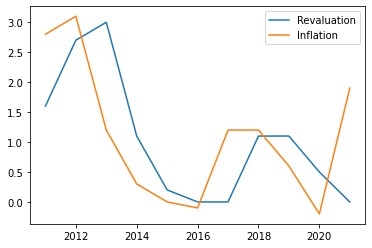

In [ ]:
years = range(2011, 2022)
revaluation = [1.6, 2.7, 3, 1.1, 0.2, 0, 0, 1.1, 1.1, 0.5, 0]
inflation =   [2.8, 3.1, 1.2, 0.3, 0, -0.1, 1.2, 1.2, 0.6, -0.2, 1.9]
plt.plot(years, revaluation, label="Revaluation")
plt.plot(years, inflation, label="Inflation")
plt.legend()
plt.show()

In [ ]:
def pension_perequation(pension_consts, f):
  for key in pension_consts.keys():
    if key.endswith("Target Pension"):
      pension_consts[key] = pension_consts[key] + pension_consts[key]* (f - 0.001) 
  return pension_consts

In [ ]:
def pension_volume(x, pension_constants):
  pens_m = 0
  pens_f = 0
  pension_types = pensions['TIPO_PENSIONE1'].unique()
  for pension_type in pension_types:
    pens_m = pens_m + sum(x[0:N] * pension_constants["male " + pension_type + " Pension Ratio"] * pension_constants["male " + pension_type + " Target Pension"])
    pens_f = pens_f  + sum(x[N:2*N] * pension_constants["female " + pension_type + " Pension Ratio"] * pension_constants["female " + pension_type + " Target Pension"])
  return pens_m + pens_f


In [ ]:
def retribution_perequation(retribution_consts, f):
  for key in retribution_consts.keys():
    if key.endswith("Employed Income"):
      retribution_consts[key] = retribution_consts[key] + retribution_consts[key] * f
  return retribution_consts

In [ ]:
def contribution_volume(x, retribution_constants, pension_constants, firstYear=False):
  contr_m = 0
  contr_f = 0
  contr_rates = {"Employed":0.33, "Self-employed":0.25, "Pensioned":0.24}
  if((not firstYear) and contrRateIncrease):
    contr_rates = {"Employed":0.4, "Self-employed":0.3, "Pensioned":0.3}
    
  for contr_type, contr_rate in contr_rates.items():
    if(contr_type != "Pensioned"):
      contr_m = contr_m + sum(x[0:N] * retribution_constants["male " + contr_type + " Ratio"] * retribution_constants["male " + contr_type + " Income"] * contr_rates[contr_type])
      contr_f = contr_f + sum(x[N:2*N] * retribution_constants["female " + contr_type + " Ratio"] * retribution_constants["female " + contr_type + " Income"] * contr_rates[contr_type])

  #add pension contributions
  pension_types = pensions['TIPO_PENSIONE1'].unique()
  for pension_type in pension_types:
    contr_m = contr_m + sum(x[0:N] * pension_constants["male " + pension_type + " Pension Ratio"] * pension_constants["male " + pension_type + " Target Pension"] * contr_rates["Pensioned"])
    contr_f = contr_f  + sum(x[N:2*N] * pension_constants["female " + pension_type + " Pension Ratio"] * pension_constants["female " + pension_type + " Target Pension"] * contr_rates["Pensioned"])
  
  return contr_m + contr_f

In [ ]:
def perequation(x, pension_constants, retribution_constants):
  #gross pension volume
  pen_vol = pension_volume(x, pension_constants)

  #employed gross income
  income_e = 0
  income_e = sum(x[0:N] * retribution_constants["male Employed Ratio"] * retribution_constants["male Employed Income"])
  income_e = income_e + sum(x[N:2*N] * retribution_constants["female Employed Ratio"] * retribution_constants["female Employed Income"])

  #self-employed gross income
  income_s = 0
  income_s = sum(x[0:N] * retribution_constants["male Self-employed Ratio"] * retribution_constants["male Self-employed Income"])
  income_s = income_s + sum(x[N:2*N] * retribution_constants["female Self-employed Ratio"] * retribution_constants["female Self-employed Income"])

  f = (income_e * 0.33 + income_s * 0.25 - pen_vol * (1 - 0.24) * (1 - 0.001))/(pen_vol * (1 - 0.24) - income_e * 0.33)
  
  return pension_perequation(pension_constants, f), retribution_perequation(retribution_constants,f), f

In [ ]:
def gradualIncreasePensAge(pension_consts, retribution_consts, pensionAgeThreshold):
  for sex in ["male", "female"]:
    pen_ratio = pension_consts[sex + " longevity Pension Ratio"][pensionAgeThreshold]
    #Pension Ratio = Pensioner Self-employed Ratio + Pensioner Employed Ratio = Pensioner Self-employed Ratio + (Pensioner Self-employed Ratio * EPSP Ratio)
    pens_selfemployed_ratio = pen_ratio /(1 + retribution_consts[sex + " EPSP Ratio"][pensionAgeThreshold])
    pens_employed_ratio = pens_selfemployed_ratio * retribution_consts[sex + " EPSP Ratio"][pensionAgeThreshold]
    retribution_consts[sex + " Self-employed Ratio"][pensionAgeThreshold] =  min(1, retribution_consts[sex + " Self-employed Ratio"][pensionAgeThreshold] + pens_selfemployed_ratio)
    retribution_consts[sex + " Employed Ratio"][pensionAgeThreshold] =  min(1, retribution_consts[sex + " Employed Ratio"][pensionAgeThreshold] + pens_employed_ratio)

  for sex, v in itertools.product(["male", "female"], ["Pension Ratio", "Target Pension"]):
    pension_consts[sex + " longevity " + v][pensionAgeThreshold] = 0

  return pension_consts, retribution_consts

In [ ]:
def update_stats(x, alpha, stats, pension_consts, retribution_consts, f=None):
  stats["Population"].append(np.sum(x))
  stats["Birth Rate"].append(np.sum(alpha))
  stats["IDR"].append(inverse_dependency_ratio(x))
  stats["Pension Volume"].append(pension_volume(x, pension_consts))
  stats["Contribution Volume"].append(contribution_volume(x, retribution_consts, pension_consts))
  stats["Pension-Contribution Ratio"].append(stats["Pension Volume"][-1] / stats["Contribution Volume"][-1])
  if(perq):
    stats["Inflation"].append(f)
  return stats

# **Without migration**

In [ ]:
years = 50
print_conv = True
displayAnimation = True
saveAnimation = False

In [ ]:
Lambda, alpha_s, x, evolution_f, evolution_m, evolution_y_f, evolution_y_m, stats_without_imm, pension_constants, retribution_constants = initialize()

#compute evolution of the populations
evolution_y_f = np.zeros((years+1,N))
evolution_y_m = np.zeros((years+1,N))

for t in range(1,years+1):
  Lambda, alpha_s, x = evolve(Lambda, alpha_s, x)
  if(gradualIncreasePensionAge and ((youngest_pensioner_age + t) < 65)):
    pension_constants, retribution_constants = gradualIncreasePensAge(pension_constants, retribution_constants, youngest_pensioner_age + t)
  if(perq):
    pension_constants, retribution_constants, f = perequation(x, pension_constants, retribution_constants)
    stats_without_imm = update_stats(x, alpha_s, stats_without_imm, pension_constants, retribution_constants, f)
  else:
    stats_without_imm = update_stats(x, alpha_s, stats_without_imm, pension_constants, retribution_constants)
  evolution_f = np.vstack([evolution_f, x[0:N]])
  evolution_m = np.vstack([evolution_m, x[N:2*N]])
  if(convergence(evolution_f, evolution_m) and print_conv):
    print("Convergence reached at year " + str(2021 + t))
    print_conv = False

print("Evolution completed")

Convergence reached at year 2046
Evolution completed


In [ ]:
#animate the evolution
fig, ax = plt.subplots()
anim1 = animation.FuncAnimation(fig,animate, init_func=init, blit=False, repeat=False, frames=len(evolution_f), interval=500)
plt.close()
HTML(anim1.to_jshtml())

# **With controlled immigration**

In [ ]:
#x_f, y_f, alpha_s are vectors without axis specified
def update_alpha_s(x_f, y_f, e_f=None, alpha_s=None, min=17, max=50):
  result = np.zeros((1,N))
  if(e_f is None):
     x_surv = omega_f[min-1: max] * x_f[min-1: max] 
  else:
    x_surv = omega_f[min-1: max] * x_f[min-1: max] - e_f[min:max+1]
  result[0][min:max+1] = (x_surv * alpha_s[min: max+1])/(x_surv + y_f[min:max+1]) + (y_f[min:max+1] * alpha_1[min: max+1])/(x_surv + y_f[min:max+1])
  return result.flatten()

In [ ]:
def compute_optimal_immigration(year, Lambda, mu, x, e=None):
  #compute eigenvalues and eigenvectors of Lambda
  w, v = LA.eig(Lambda)  
  #index of real positive eigenvalue
  w0_idx = [idx for idx, element in enumerate(w) if (element.real > 0) and (element.imag == 0)][0]
  z = v[:, w0_idx]  
  #print("Vector norm: " + str(np.linalg.norm(z)))   
  z = np.real(abs(z)).reshape(2*N,1)    #normalized real positive eigenvector

  evol = Lambda @ x.reshape(2*N,1)   #column vector

  if(e is None):
    u = np.max(evol/z) 
    y = (1-mu**(year+1))*((u * z) - evol)
  else:
    e = e.reshape(2*N,1)               #column vector
    u = np.max((evol - e)/z) 
    y = (1-mu**(year+1))*((u * z) - evol + e)

  return y.flatten()

In [ ]:
Lambda, alpha_s, x, evolution_f, evolution_m, evolution_y_f, evolution_y_m, stats_controlled_imm, pension_constants, retribution_constants = initialize()
#compute evolution of the populations
mu = 0.9                                      #parameter of convergence
max_y_age = 32
print_conv = True

for t in range(1,years+1):
  y = compute_optimal_immigration(t, Lambda, mu, x, e=e)

  #exclude immigrants older than 32 y.o.
  z = np.arange(0,N)
  T = 4.0
  #shifted (max_y_age) modulated (T) reverse (z) sigmoid
  sigmoid = 1.0/(1.0 + np.exp((z - max_y_age)/T))
  #plt.plot(sigmoid)
  y[0:N] = y[0:N] * sigmoid
  y[N:2*N] = y[N:2*N] * sigmoid

  evolution_y_f = np.vstack([evolution_y_f, y[0:N]])
  evolution_y_m = np.vstack([evolution_y_m, y[N:2*N]])
  #print("Immigration volume at year " + str(2021 + t) + ": " + str(np.sum(young_y[0:N]) + np.sum(young_y[N:2*N])))

  Lambda, alpha_s, x = evolve(Lambda, alpha_s, x, y=y, e=e)

  if(gradualIncreasePensionAge and ((youngest_pensioner_age + t) < 65)):
      pension_constants, retribution_constants = gradualIncreasePensAge(pension_constants, retribution_constants, youngest_pensioner_age + t)
  if(perq):
    pension_constants, retribution_constants, f = perequation(x, pension_constants, retribution_constants)
    stats_controlled_imm = update_stats(x, alpha_s, stats_controlled_imm, pension_constants, retribution_constants, f)
  else:
    stats_controlled_imm = update_stats(x, alpha_s, stats_controlled_imm, pension_constants, retribution_constants)
  evolution_f = np.vstack([evolution_f, x[0:N]])
  evolution_m = np.vstack([evolution_m, x[N:2*N]])

  if(convergence(evolution_f, evolution_m) and print_conv):
    print("Convergence reached at year " + str(2021 + t))
    print_conv = False

print("Evolution completed")

Convergence reached at year 2039
Evolution completed


In [ ]:
#animate the evolution 
fig, ax = plt.subplots()
anim2 = animation.FuncAnimation(fig,animate, init_func=init, blit=False, repeat=False, frames=len(evolution_f), interval=500)
plt.close()
HTML(anim2.to_jshtml())

# **With current migration**

In [ ]:
Lambda, alpha_s, x, evolution_f, evolution_m, evolution_y_f, evolution_y_m, stats_imm, pension_constants, retribution_constants = initialize()

#compute evolution of the populations
print_conv = True

for t in range(1,years+1):
  evolution_y_f = np.vstack([evolution_y_f, i[0:N]])
  evolution_y_m = np.vstack([evolution_y_m, i[N:2*N]])

  Lambda, alpha_s, x = evolve(Lambda, alpha_s, x, y=i, e=e)
  if(gradualIncreasePensionAge and ((youngest_pensioner_age + t) < 65)):
    pension_constants, retribution_constants = gradualIncreasePensAge(pension_constants, retribution_constants, youngest_pensioner_age + t)
  if(perq):
    pension_constants, retribution_constants, f = perequation(x, pension_constants, retribution_constants)
    stats_imm = update_stats(x, alpha_s, stats_imm, pension_constants, retribution_constants, f)
  else:
    stats_imm = update_stats(x, alpha_s, stats_imm, pension_constants, retribution_constants)
  evolution_f = np.vstack([evolution_f, x[0:N]])
  evolution_m = np.vstack([evolution_m, x[N:2*N]])

  if(convergence(evolution_f, evolution_m) and print_conv):
    print("Convergence reached at year " + str(2021 + t))
    print_conv = False

print("Evolution completed")

Convergence reached at year 2042
Evolution completed


In [ ]:
#animate the evolution 
fig, ax = plt.subplots()
anim3 = animation.FuncAnimation(fig,animate, init_func=init, blit=False, repeat=False, frames=len(evolution_f), interval=500)
plt.close()
HTML(anim3.to_jshtml())

In [ ]:
if(saveAnimation):
  writergif = animation.PillowWriter(fps=10) 
  anim1.save('/content/plots/withoutMigration.gif', writer=writergif)
  anim2.save('/content/plots/withControlledMigration.gif', writer=writergif) 
  anim3.save('/content/plots/withCurrentMigration.gif', writer=writergif)

#**Results**

In [ ]:
  if(decreasePensions and gradualIncreasePensionAge and contrRateIncrease and occupationIncrease):
    measure_type = "allMeasures"
  elif(decreasePensions):
    measure_type = "pensionDecrease"
  elif(gradualIncreasePensionAge):
    measure_type = "pensionAgeIncrease"
  elif(contrRateIncrease):
    measure_type = "contributionIncrease"
  elif(occupationIncrease):
    measure_type = "occupationIncrease"
  else:
    measure_type = "noMeasures"

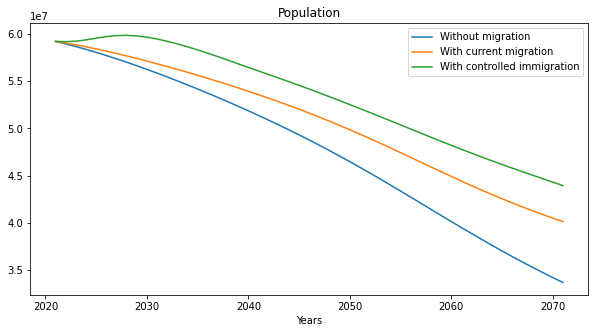

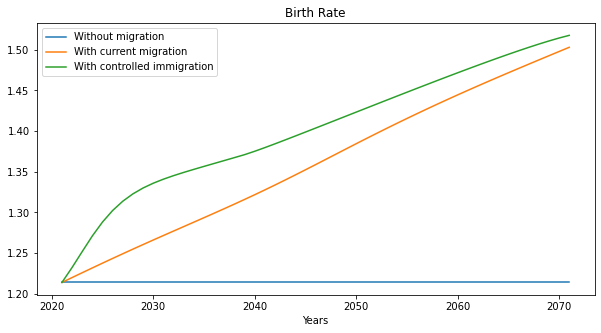

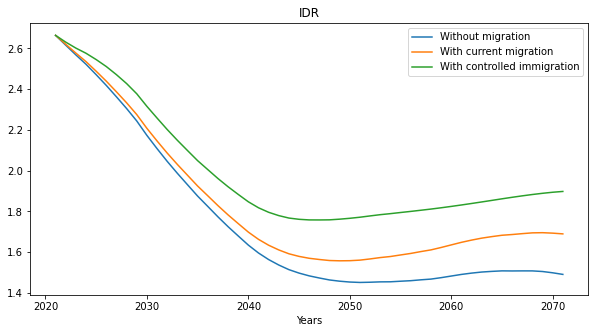

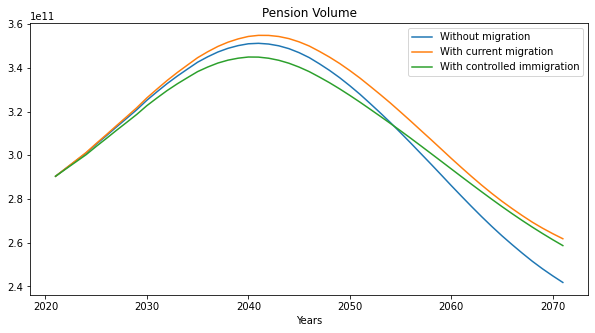

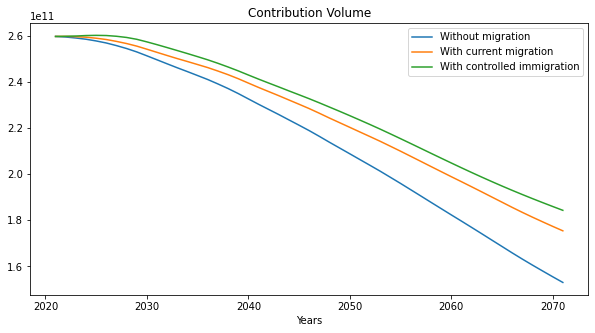

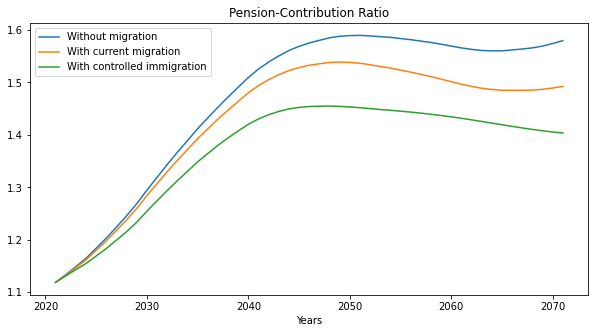

In [ ]:
stats_names = stats_imm.keys()
for stat_name in stats_names:
  plt.figure(figsize=(10,5))
  plt.plot(range(2021, 2021 + len(stats_without_imm[stat_name])), stats_without_imm[stat_name], label="Without migration")
  plt.plot(range(2021, 2021 + len(stats_imm[stat_name])), stats_imm[stat_name], label="With current migration")
  plt.plot(range(2021, 2021 + len(stats_controlled_imm[stat_name])), stats_controlled_imm[stat_name], label="With controlled immigration")
  plt.title(stat_name)
  plt.xlabel("Years")
  plt.legend()
  if(stat_name == "Pension-Contribution Ratio"):
    plt.savefig("/content/plots/PCR_" + measure_type + ".png")
  elif(stat_name in ["Population", "IDR", "Birth Rate"] and measure_type == "noMeasures"):
    plt.savefig("/content/plots/" + stat_name.replace(" ", "") + "Evolution.png")
  plt.show()